In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list, set_attrs
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import matplotlib
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
# plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
import os
from geocat.comp.interpolation import interp_hybrid_to_pressure
print(os.getcwd())

/home/users/jamd1/Isca


In [2]:
cesm.get_exp_file_dates('test', hist_file=1)

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['0041-01-02T00:00:00', '0042-01-02T00:00:00',
       '0043-01-02T00:00:00'], dtype='datetime64[s]')
Dimensions without coordinates: time

In [21]:
var_atm = ['T', 'Q', 'Z3', 'PS', 'P0', 'hyam', 'hybm', 'gw']
ds = cesm.load_dataset('test', hist_file=1, month_files=None, year_files='first10')[var_atm]


/home/users/jamd1/Isca/isca_tools/cesm/load.py:88: UserWarning: year_files=first10 but there are only 3 years available:
[41, 42, 43]
  warnings.warn(f"year_files={year_files} but there are only "


In [23]:
ds.time

<xarray.DataArray 'time' (time: 6)> Size: 48B
array([cftime.DatetimeNoLeap(31, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(31, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(31, 1, 4, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(31, 1, 5, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(31, 1, 6, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(31, 1, 7, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 48B 0031-01-02 00:00:00 ... 0031-01-07 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [10]:
# Remove time dependence of variables constant in time
p_ref = ds.P0.isel(time=0)
hyam = ds.hyam.isel(time=0)
hybm = ds.hybm.isel(time=0)

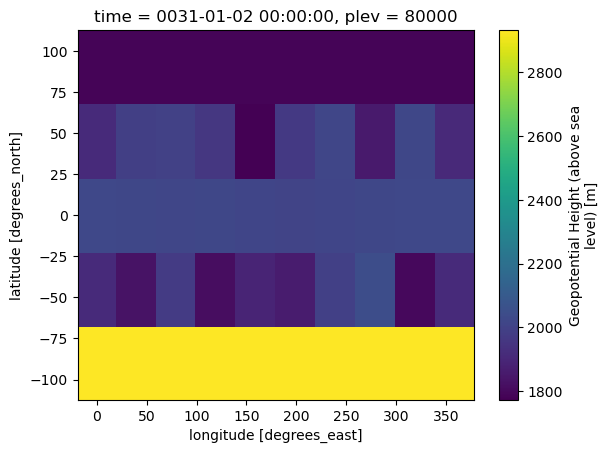

In [11]:
interp_hybrid_to_pressure(ds.Z3, ds.PS, hyam, hybm, p_ref, np.asarray([800*100]), extrapolate=True, variable='other').isel(time=0, plev=0).plot()

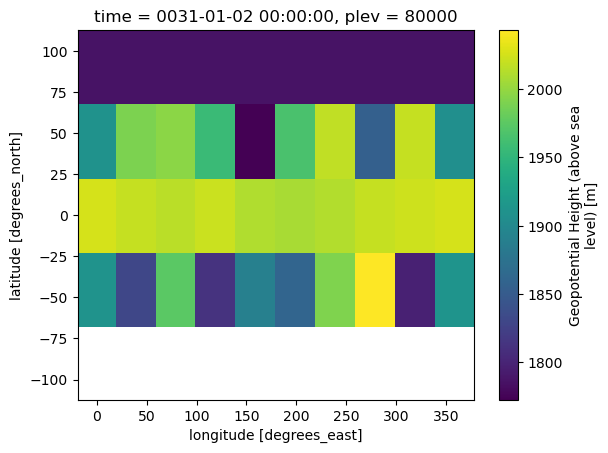

In [12]:
interp_hybrid_to_pressure(ds.Z3, ds.PS, hyam, hybm, p_ref, np.asarray([800*100])).isel(time=0, plev=0).plot()

In [14]:
exp = 'e.e20.E1850TEST.f09_g17'
ds_ref = cesm.load_dataset(f'{exp}.co2_2x_daily_output', hist_file=1, year_files=32)[['P0', 'hyam', 'hybm']]
ds_ref = ds_ref.isel(time=0).load()
ds_full = cesm.load_dataset(f'{exp}.co2_2x_daily_output', hist_file=1, year_files=32)[['PS', 'T', 'Z3']]

In [17]:
%%time
ds_full.load()

CPU times: user 2.47 s, sys: 12.9 s, total: 15.4 s
Wall time: 1min 35s


<xarray.Dataset> Size: 5GB
Dimensions:  (time: 365, lat: 192, lon: 288, lev: 32)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) object 3kB 0032-01-02 00:00:00 ... 0033-01-01 00:00:00
Data variables:
    PS       (time, lat, lon) float32 81MB 6.927e+04 6.927e+04 ... 1.027e+05
    T        (time, lev, lat, lon) float32 3GB 267.2 267.2 267.2 ... 261.9 261.9
    Z3       (time, lev, lat, lon) float32 3GB 3.945e+04 3.945e+04 ... 57.41
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              e.e20.E1850TEST.f09_g17.co2_2x_daily_output
    logname:           jamd
    host:              ln01
    initial_file:      /work/n02/n02/jamd/cesm/CESM2.1.3/cesm_inputdata/atm/c...
    topography_file:   /work/n02/n02/jamd/cesm/CESM2.1.3/cesm_inputdata/atm/c...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

In [18]:
t500 = interp_hybrid_to_pressure(ds_full.T, ds_full.PS, ds_ref.hyam, ds_ref.hybm, ds_ref.P0, np.asarray([500*100]))
z500 = interp_hybrid_to_pressure(ds_full.T, ds_full.PS, ds_ref.hyam, ds_ref.hybm, ds_ref.P0, np.asarray([500*100]))

In [19]:
ds_out = xr.Dataset({'Z3': z500, 'T': t500})
set_attrs(ds_out.plev, long_name='pressure', units='Pa')

<xarray.DataArray 'plev' (plev: 1)> Size: 8B
array([50000])
Coordinates:
  * plev     (plev) int64 8B 50000
Attributes:
    long_name:  pressure
    units:      Pa

In [118]:
encoding = {var: {'zlib': True, 'complevel': 4} for var in ds_out.data_vars}
out_path = '/gws/nopw/j04/global_ex/jamd1/cesm/test.nc'
# ds_out.to_netcdf(out_path, encoding=encoding)